In [45]:
# ============================================================
#  (1) Clean long_df (2023, filtered core blocks + filtered QIDs + removed forced-choice batteries)
#  (2) Top polarizing questions (weighted variance) + statement text (no duplicates like Q173)
#  (3) 3-case violin plot (population distribution + population median + one respondent point)
#  (4) Response-style violin (extreme-scale user vs central-scale user)
#  (5) Importance score:
#        d_pop = endorsement - population_median_w
#        z_iq  = (endorsement - personal_mean_i) / personal_sd_i
#        importance_score = |d_pop| * |z_iq|
#      + top-10 beliefs per person
#      + 3 archetypes (high density / flat / conflicting)
#      + worldview-relevant map for each of the 3 archetypes
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

# ============================================================
# 0) PATHS + LOAD
# ============================================================

normalized_path = "WVS_wave7_normalized_weighted.csv"
meta_path       = "WVS spreadsheet.xlsx"

normalized = pd.read_csv(normalized_path, low_memory=False)
meta = pd.read_excel(meta_path)


In [47]:

# ============================================================
# 1) FILTER TO ONE YEAR (2023) + IDENTIFY QUESTION COLUMNS
# ============================================================

normalized_2023 = normalized.loc[normalized["A_YEAR"] == 2023].copy()
print("Rows in 2023 subset:", normalized_2023.shape[0])

norm_cols = [c for c in normalized_2023.columns if c.endswith("_norm")]
if not norm_cols:
    raise ValueError("No *_norm columns found. Check your normalized file.")

normalized_2023 = normalized_2023.reset_index(drop=True)
normalized_2023["respondent_id"] = normalized_2023.index  # each row is one respondent


Rows in 2023 subset: 1692


In [48]:

# ============================================================
# 2) METADATA MAP: Question_norm -> Question_ID -> Core/Family
# ============================================================

meta_q = meta[["Question_ID", "Variable_Family", "Core_Variables"]].copy()
meta_q = meta_q.dropna(subset=["Question_ID"])
meta_q["Question_ID"] = meta_q["Question_ID"].astype(str).str.strip()

question_ids = [c.replace("_norm", "") for c in norm_cols]

q_map = (
    pd.DataFrame({"Question_ID": question_ids, "Question_norm": norm_cols})
    .merge(meta_q, on="Question_ID", how="left")
)

print("Share missing Core_Variables in metadata:", q_map["Core_Variables"].isna().mean())


Share missing Core_Variables in metadata: 0.0


In [49]:

# ============================================================
# 3) WIDE -> LONG (endorsement = normalized response 0..1)
# ============================================================

long_df = normalized_2023.melt(
    id_vars=["respondent_id", "B_COUNTRY_ALPHA", "W_WEIGHT"],
    value_vars=norm_cols,
    var_name="Question_norm",
    value_name="endorsement"
)

long_df = long_df.dropna(subset=["endorsement"]).copy()
long_df = long_df.merge(q_map, on="Question_norm", how="left")

long_df["Question_ID"] = long_df["Question_ID"].astype(str).str.strip()


In [50]:

# ============================================================
# 4) DROP 3 CORE BLOCKS COMPLETELY (your requirement)
# ============================================================

drop_core_blocks = {
    "Social Capital, Trust and Organizational Membership (Q57-Q105)",
    "Political Interest & Political Participation (Q199–Q234)",
    "Political Interest & Political Participation (Q199-Q234)",  # defensive
    "Demographic and Socioeconomic Variables (Q260-\nQ290)",
    "Demographic and Socioeconomic Variables (Q260-Q290)"       # defensive
}

before = long_df.shape[0]
long_df = long_df.loc[~long_df["Core_Variables"].isin(drop_core_blocks)].copy()
after = long_df.shape[0]
print(f"Dropped core blocks rows: {before - after:,} | remaining: {after:,}")


Dropped core blocks rows: 164,690 | remaining: 356,955


In [51]:

# ============================================================
# 5) DROP PROBLEMATIC / FORCED-CHOICE / BATTERY QUESTIONS (QIDs)
#    - Remove binary mentioned/not mentioned batteries
#    - Remove forced-choice A/B items
#    - Remove religion self-ID battery duplicates like Q173
#    - Remove Postmaterialism forced-choice battery (Q152..Q157) -> gives many 0/1 artifacts
# ============================================================

exclude_qids = set()

# Social Values: "children qualities" (mentioned / not mentioned) battery
exclude_qids.update([f"Q{i}" for i in range(7, 18)])   # Q7..Q17

# Social Values: "not as neighbors" battery (mentioned / not mentioned)
exclude_qids.update([f"Q{i}" for i in range(18, 27)])  # Q18..Q26

# Revolutionary action / scenario (your earlier note)
exclude_qids.update(["Q42"])

# Wellbeing scarcity / factual-ish items you wanted to drop
exclude_qids.update(["Q51", "Q52", "Q53", "Q54", "Q55"])

# Security behavior / factual / forced-choice items
exclude_qids.update(["Q111", "Q139", "Q140", "Q141", "Q144", "Q145", "Q151"])
exclude_qids.update(["Q149", "Q150"])  # forced choice A vs B

# Religion yes/no + frequency + forced-choice + self-id battery causing duplicates
exclude_qids.update(["Q165", "Q166", "Q167", "Q168"])
exclude_qids.update(["Q171", "Q172", "Q172R"])
exclude_qids.update(["Q174", "Q175"])
exclude_qids.update(["Q173"])  # key: removes the duplicated “religious/atheist/not religious” variants

# Postmaterialism forced-choice battery (removes the “endorsement=0 everywhere” artifacts)
exclude_qids.update([f"Q{i}" for i in range(152, 158)])  # Q152..Q157

# Defensive: country-specific party variables if present
exclude_qids.update(["Q223", "Q223_ABREV", "Q223_LOCAL"])

before = long_df.shape[0]
long_df = long_df.loc[~long_df["Question_ID"].isin(exclude_qids)].copy()
after = long_df.shape[0]
print(f"Dropped excluded QIDs rows: {before - after:,} | remaining: {after:,}")


Dropped excluded QIDs rows: 115,225 | remaining: 241,730


In [52]:

# ============================================================
# 6) CANONICAL STATEMENT LOOKUP (1 row per Question_ID)
#    Priority: Selection_1_Jan==1, else longest statement
# ============================================================

cols = ["Question_ID", "Worldview_Statement"]
q_text = meta[cols].copy()

q_text["Question_ID"] = q_text["Question_ID"].astype(str).str.strip()

if "Selection_1_Jan" in meta.columns:
    q_text["sel"] = meta["Selection_1_Jan"].fillna(0).astype(int).values
else:
    q_text["sel"] = 0

q_text = q_text.dropna(subset=["Question_ID", "Worldview_Statement"]).copy()
q_text["stmt_len"] = q_text["Worldview_Statement"].astype(str).str.len()

q_text = (
    q_text
    .sort_values(["Question_ID", "sel", "stmt_len"], ascending=[True, False, False])
    .drop_duplicates(subset=["Question_ID"])
    .loc[:, ["Question_ID", "Worldview_Statement"]]
    .copy()
)

missing_qids = sorted(set(long_df["Question_ID"].dropna()) - set(q_text["Question_ID"]))
print("Missing QIDs in statement lookup (after canonical):", len(missing_qids))
print(missing_qids[:30])

# Attach statement to long_df early (so every downstream table has text)
long_df = long_df.merge(q_text, on="Question_ID", how="left")


Missing QIDs in statement lookup (after canonical): 0
[]


In [53]:

# ============================================================
# 7) HELPERS: WEIGHTED MEAN / VAR / WEIGHTED MEDIAN
# ============================================================

def weighted_mean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    s = np.sum(w)
    return np.sum(x * w) / s if s > 0 else np.nan

def weighted_variance(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    s = np.sum(w)
    if s <= 0:
        return np.nan
    mu = np.sum(x * w) / s
    return np.sum(w * (x - mu) ** 2) / s

def weighted_quantile(values, quantiles, sample_weight):
    values = np.asarray(values, dtype=float)
    quantiles = np.asarray(quantiles, dtype=float)
    w = np.asarray(sample_weight, dtype=float)

    m = np.isfinite(values) & np.isfinite(w)
    values, w = values[m], w[m]
    if values.size == 0:
        return np.array([np.nan] * len(quantiles))

    sorter = np.argsort(values)
    values, w = values[sorter], w[sorter]

    cum_w = np.cumsum(w)
    cum_w = cum_w / cum_w[-1]
    return np.interp(quantiles, cum_w, values)


/var/folders/90/cj9y9x_11md6q6v4jh0brwbm0000gn/T/ipykernel_86544/1385075731.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_df



Example respondent_id for 3-case violins: 0


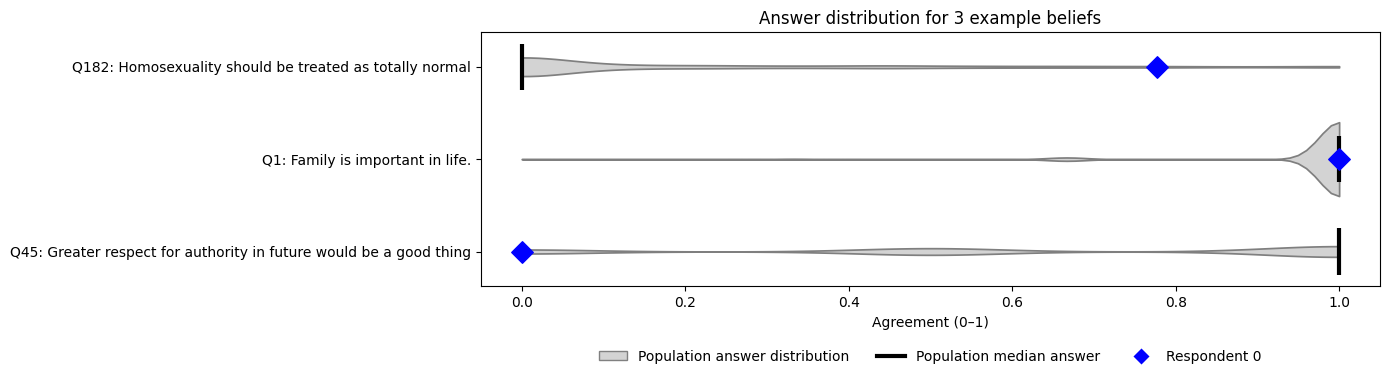

In [55]:

# ============================================================
# 8) 3-CASE VIOLIN (population distribution + population median line + one respondent point)
#    Pick 3 questions for one respondent:
#      (A) individual >> population median (signed high)
#      (B) individual ~ population median (closest)
#      (C) population median >> individual (signed low)
# ============================================================

# --- population weighted median per question ---
pop_median_w = (
    long_df
    .groupby("Question_ID")
    .apply(lambda g: weighted_quantile(g["endorsement"], [0.5], g["W_WEIGHT"])[0])
    .rename("population_median")
    .reset_index()
)

# choose an example respondent (you can set manually)
example_respondent = int(long_df["respondent_id"].iloc[0])
print("\nExample respondent_id for 3-case violins:", example_respondent)

ind = long_df.loc[long_df["respondent_id"] == example_respondent, ["Question_ID","endorsement","Worldview_Statement"]].copy()
ind = ind.merge(pop_median_w, on="Question_ID", how="left")

# signed deviation from population median
ind["d_pop_signed"] = ind["endorsement"] - ind["population_median"]

# choose cases
case_high   = ind.sort_values("d_pop_signed", ascending=False).iloc[0]         # individual much higher
case_close  = ind.iloc[(ind["d_pop_signed"].abs()).argsort().iloc[0]]          # closest
case_low    = ind.sort_values("d_pop_signed", ascending=True).iloc[0]          # population much higher

cases = pd.DataFrame([case_high, case_close, case_low]).copy()

# build population subset for these questions
subset_pop = long_df.loc[long_df["Question_ID"].isin(cases["Question_ID"]), ["Question_ID","endorsement"]].copy()
subset_pop = subset_pop.merge(q_text, on="Question_ID", how="left")
subset_pop = subset_pop.merge(pop_median_w, on="Question_ID", how="left")

# keep stable order = [high, close, low]
order_qids = cases["Question_ID"].tolist()
label_map = {}
for _, r in cases.iterrows():
    stmt = r["Worldview_Statement"]
    if pd.isna(stmt):
        stmt = ""
    stmt = str(stmt).strip()
    stmt_short = stmt if len(stmt) <= 70 else (stmt[:69] + "…")
    label_map[r["Question_ID"]] = f'{r["Question_ID"]}: {stmt_short}'

subset_pop["Question_Label"] = subset_pop["Question_ID"].map(label_map)
cases["Question_Label"] = cases["Question_ID"].map(label_map)

subset_pop["Question_Label"] = pd.Categorical(
    subset_pop["Question_Label"],
    categories=[label_map[q] for q in order_qids],
    ordered=True
)

plt.figure(figsize=(14, 4))
ax = sns.violinplot(
    data=subset_pop,
    x="endorsement",
    y="Question_Label",
    cut=0,
    inner=None,
    color="lightgrey"
)

# population median as vertical line segment
for i, qid in enumerate(order_qids):
    med = float(subset_pop.loc[subset_pop["Question_ID"] == qid, "population_median"].iloc[0])
    ax.vlines(med, i - 0.25, i + 0.25, color="black", linewidth=3, zorder=5)

# individual as blue diamond
for i, row in cases.reset_index(drop=True).iterrows():
    ax.scatter(row["endorsement"], i, color="blue", s=120, marker="D", zorder=6)

ax.set_title("Answer distribution for 3 example beliefs")
ax.set_xlabel("Agreement (0–1)")
ax.set_ylabel("")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="grey", label="Population answer distribution"),
    Line2D([0],[0], color="black", linewidth=3, label="Population median answer"),
    Line2D([0],[0], marker="D", color="w", markerfacecolor="blue", markersize=9, label=f"Respondent {example_respondent}")
]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.20),
          ncol=3, frameon=False, fontsize=10)

plt.tight_layout()
plt.show()



Extreme-scale user: {'respondent_id': 585.0, 'mean_endorsement': 0.5646666666666667, 'sd_endorsement': 0.48508950509879006, 'n_answers': 125.0}
Central-scale user: {'respondent_id': 149.0, 'mean_endorsement': 0.48723325974981607, 'sd_endorsement': 0.1950169294138825, 'n_answers': 151.0}


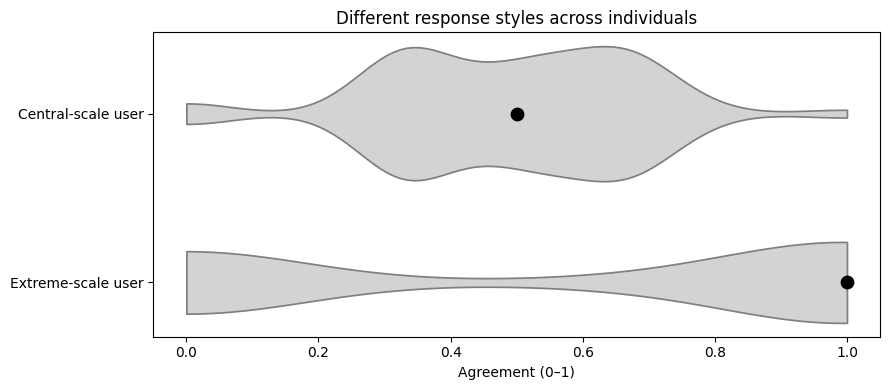

In [ ]:

# ============================================================
# 9) RESPONSE STYLE (extreme-scale user vs central-scale user)
#     Show how two people use the endorsement scale differently
# ============================================================

person_style = (
    long_df
    .groupby("respondent_id")["endorsement"]
    .agg(mean_endorsement=("mean"), sd_endorsement=("std"), n_answers=("count"))
    .reset_index()
)

# remove people with sd=0 or too few answers (defensive)
person_style = person_style.loc[person_style["sd_endorsement"].fillna(0) > 0].copy()
person_style = person_style.loc[person_style["n_answers"] >= 20].copy()

high_extreme = person_style.sort_values("sd_endorsement", ascending=False).iloc[0]
low_extreme  = person_style.sort_values("sd_endorsement", ascending=True).iloc[0]

person_ids = [int(high_extreme["respondent_id"]), int(low_extreme["respondent_id"])]

print("\nExtreme-scale user:", high_extreme.to_dict())
print("Central-scale user:", low_extreme.to_dict())

subset = long_df.loc[long_df["respondent_id"].isin(person_ids), ["respondent_id","endorsement"]].copy()

subset["Responder type"] = subset["respondent_id"].map({
    person_ids[0]: "Extreme-scale user",
    person_ids[1]: "Central-scale user"
})

plt.figure(figsize=(9, 4))
sns.violinplot(
    data=subset,
    x="endorsement",
    y="Responder type",
    cut=0,
    inner=None,
    color="lightgrey"
)

medians = subset.groupby("Responder type")["endorsement"].median()
for i, m in enumerate(medians):
    plt.scatter(m, i, color="black", s=80, zorder=4)

plt.xlabel("Agreement (0–1)")
plt.ylabel("")
plt.title("Different response styles across individuals")
plt.tight_layout()
plt.show()


In [57]:

# ============================================================
# 10) IMPORTANCE SCORE (agreed definition)
#     d_pop = endorsement - population median (weighted)
#     z_iq  = (endorsement - mean_i) / sd_i
#     importance_score = |d_pop| * |z_iq|
# ============================================================

# --- population stats per question (weighted median) ---
pop_stats = pop_median_w.copy()  # contains Question_ID, population_median

# --- personal stats per respondent (mean_i, sd_i) ---
person_stats = (
    long_df
    .groupby("respondent_id")["endorsement"]
    .agg(personal_mean=("mean"), personal_sd=("std"))
    .reset_index()
)

# guard: sd=0 -> NaN
person_stats["personal_sd"] = person_stats["personal_sd"].replace(0, np.nan)

# merge stats into long_df
df = long_df.merge(pop_stats, on="Question_ID", how="left")
df = df.merge(person_stats, on="respondent_id", how="left")

# compute deviations
df["d_pop"] = df["endorsement"] - df["population_median"]                     # signed deviation from population
df["z_iq"]  = (df["endorsement"] - df["personal_mean"]) / df["personal_sd"]   # personal z-score

# importance (only where z is defined)
df["importance_score"] = df["d_pop"].abs() * df["z_iq"].abs()


In [58]:

# ============================================================
# 11) TOP-10 WORLDVIEW BELIEFS PER PERSON
# ============================================================

top_k = 10

top_beliefs_per_person = (
    df
    .dropna(subset=["importance_score"])
    .sort_values("importance_score", ascending=False)
    .groupby("respondent_id", as_index=False, group_keys=False)
    .head(top_k)
    .copy()
)

# keep essential columns only
top_beliefs_per_person = top_beliefs_per_person.loc[:, [
    "respondent_id",
    "Question_ID",
    "Worldview_Statement",
    "endorsement",
    "population_median",
    "personal_mean",
    "d_pop",
    "z_iq",
    "importance_score",
    "Core_Variables"
]].copy()

print("\nExample: top-10 beliefs for respondent 0 (if exists):")
if (top_beliefs_per_person["respondent_id"] == 0).any():
    display(top_beliefs_per_person.query("respondent_id == 0"))
else:
    display(top_beliefs_per_person.head(10))



Example: top-10 beliefs for respondent 0 (if exists):


,respondent_id,Question_ID,Worldview_Statement,endorsement,population_median,personal_mean,d_pop,z_iq,importance_score,Core_Variables
42715,0,Q45,Greater respect for authority in future would ...,0.0,1.000000,0.486,-1.000000,-1.309085,1.309085,"Social Values, Norms, Stereotypes (Q1-Q45)"
19862,0,Q33,"When jobs are scarce, men should have more rig...",0.0,0.750000,0.486,-0.750000,-1.309085,0.981814,"Social Values, Norms, Stereotypes (Q1-Q45)"
104825,0,Q137,Street violence and fights occur very frequently,1.0,0.333333,0.486,0.666667,1.384506,0.923004,Perceptions of Security (Q131-Q151)
96513,0,Q132,Robberies occur very frequently in my neighbor...,1.0,0.333333,0.486,0.666667,1.384506,0.923004,Perceptions of Security (Q131-Q151)
109665,0,Q143,I am very worried about not giving my children...,0.0,0.666667,0.486,-0.666667,-1.309085,0.872723,Perceptions of Security (Q131-Q151)
13385,0,Q29,Men make better political leaders than women.,0.0,0.666667,0.486,-0.666667,-1.309085,0.872723,"Social Values, Norms, Stereotypes (Q1-Q45)"
16648,0,Q31,Men make better business executives than women.,0.0,0.666667,0.486,-0.666667,-1.309085,0.872723,"Social Values, Norms, Stereotypes (Q1-Q45)"
73482,0,Q119,Women are less corrupt than men,0.0,0.666667,0.486,-0.666667,-1.309085,0.872723,Perceptions of Corruption (Q112-Q120)
216325,0,Q244,In a democracy it is essential that people rec...,0.1,0.800000,0.486,-0.700000,-1.039726,0.727808,Political Culture and Political Regimes (Q235-...
122483,0,Q162,It is not important for me to know about scien...,0.0,0.555556,0.486,-0.555556,-1.309085,0.727269,Perceptions about Science and Technology (Q158...


In [65]:
# ============================================================
# WORLDVIEW DENSITY DISTRIBUTION (REAL STRONG BELIEFS)
# Strong = above BOTH mean thresholds:
# |z_iq| >= mean(|z_iq|) AND |d_pop| >= mean(|d_pop|)
# ============================================================

# 1) 
thr = (
    df.groupby("respondent_id")
    .agg(
        z_thr=("z_iq", lambda x: np.nanmean(np.abs(x))),
        d_thr=("d_pop", lambda x: np.nanmean(np.abs(x)))
    )
    .reset_index()
)

df_thr = df.merge(thr, on="respondent_id", how="left")

# 2) strong belief 
df_thr["is_strong"] = (
    (df_thr["z_iq"].abs() >= df_thr["z_thr"]) &
    (df_thr["d_pop"].abs() >= df_thr["d_thr"])
)

# 3) 
wv_density = (
    df_thr.groupby("respondent_id")["is_strong"]
    .sum()
    .rename("n_strong_beliefs")
    .reset_index()
)

print(wv_density["n_strong_beliefs"].describe())


count    1692.000000
mean       33.934397
std        11.131803
min         3.000000
25%        27.000000
50%        33.000000
75%        41.000000
max        70.000000
Name: n_strong_beliefs, dtype: float64


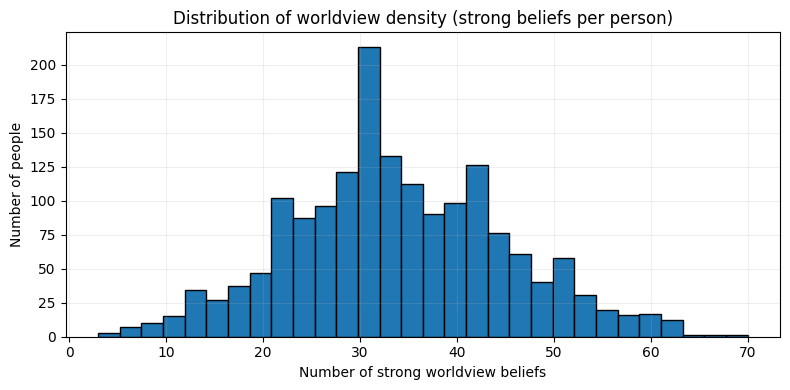

In [64]:
plt.figure(figsize=(8, 4))
plt.hist(wv_density["n_strong_beliefs"], bins=30, edgecolor="black")
plt.xlabel("Number of strong worldview beliefs")
plt.ylabel("Number of people")
plt.title("Distribution of worldview density (strong beliefs per person)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 13) HELPERS: WEIGHTED MEAN / WEIGHTED SD / WEIGHTED MEDIAN
# ============================================================

def weighted_mean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    s = np.sum(w)
    return np.sum(x * w) / s if s > 0 else np.nan


def weighted_std(x, w):
    """
    Population-weighted standard deviation
    (consistent with variance / sum(w))
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    s = np.sum(w)
    if s <= 0:
        return np.nan
    mu = np.sum(x * w) / s
    var = np.sum(w * (x - mu) ** 2) / s
    return np.sqrt(var)


def weighted_quantile(values, quantiles, sample_weight):
    values = np.asarray(values, dtype=float)
    quantiles = np.asarray(quantiles, dtype=float)
    w = np.asarray(sample_weight, dtype=float)

    m = np.isfinite(values) & np.isfinite(w)
    values, w = values[m], w[m]
    if values.size == 0:
        return np.array([np.nan] * len(quantiles))

    sorter = np.argsort(values)
    values, w = values[sorter], w[sorter]

    cum_w = np.cumsum(w)
    cum_w = cum_w / cum_w[-1]
    return np.interp(quantiles, cum_w, values)


[debug] plotting person_id=78, adjustText=True
[debug] rows after dropna(d_pop,z_iq): 149
[debug] green count: 29


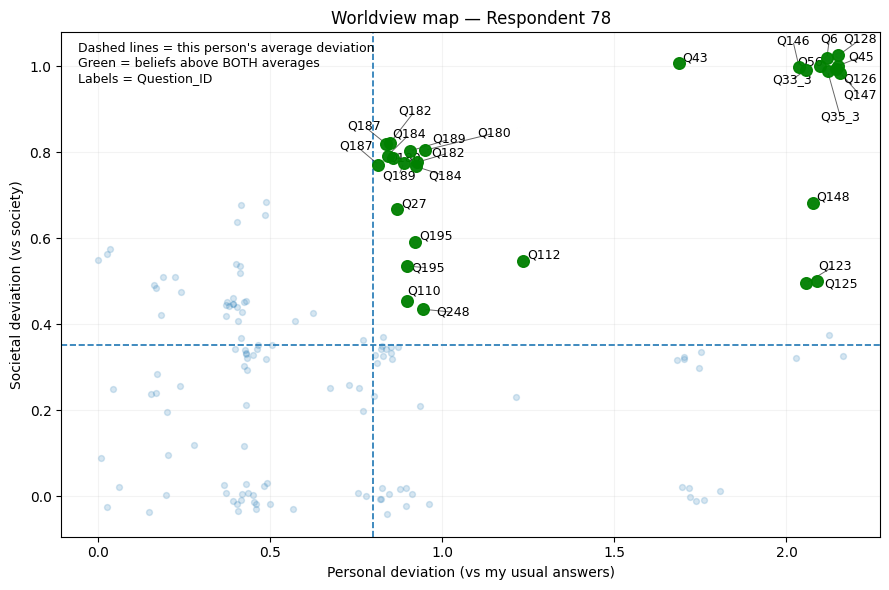

,Question_ID,Worldview_Statement,importance_score,Core_Variables
8459,Q6,Religion is important in life.,2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
52789,Q56,My standard of living is better than my parent...,2.104862,Happiness and Wellbeing (Q46-Q56)
111293,Q146,I am very worried about a war involving my cou...,2.104862,Perceptions of Security (Q131-Q151)
87144,Q128,Immigrants increase unemployment,2.104862,Perceptions of Migration (Q121-Q130)
84103,Q126,Immigrants increase the risks of terrorism,2.104862,Perceptions of Migration (Q121-Q130)
112932,Q147,I am very worried about a terrorist attack,2.104862,Perceptions of Security (Q131-Q151)
42791,Q45,Greater respect for authority in future would ...,2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
28191,Q35_3,"If a woman earns more than her husband, it alm...",2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
21602,Q33_3,"When jobs are scarce, men should have more rig...",2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
39511,Q43,Less importance placed on work in future would...,1.718790,"Social Values, Norms, Stereotypes (Q1-Q45)"


In [69]:

%matplotlib inline


try:
    from adjustText import adjust_text
    HAS_ADJUSTTEXT = True
except Exception:
    HAS_ADJUSTTEXT = False

def _stable_jitter(arr, seed=0, scale=0.020):
    a = np.asarray(arr, dtype=float)
    rng = np.random.default_rng(seed)
    span = np.nanmax(a) - np.nanmin(a)
    if not np.isfinite(span) or span == 0:
        span = 1.0
    return a + rng.normal(0, scale * span, size=a.shape)

def plot_worldview_map_xy_green_all(person_id, df, title_suffix=""):
    print(f"[debug] plotting person_id={person_id}, adjustText={HAS_ADJUSTTEXT}")

    cols = ["Question_ID","Worldview_Statement","endorsement","d_pop","z_iq","importance_score","Core_Variables"]
    one = df.loc[df["respondent_id"] == person_id, cols].copy()
    one = one.dropna(subset=["d_pop","z_iq"])

    print("[debug] rows after dropna(d_pop,z_iq):", one.shape[0])
    if one.shape[0] < 20:
        print(f"Respondent {person_id}: too few valid points ({one.shape[0]}).")
        return None

    one["x_personal"] = one["z_iq"].abs()
    one["y_society"]  = one["d_pop"].abs()

    x_thr = float(one["x_personal"].mean())
    y_thr = float(one["y_society"].mean())

    one["green"] = (one["x_personal"] >= x_thr) & (one["y_society"] >= y_thr)
    idx_g = np.where(one["green"].values)[0]
    print("[debug] green count:", len(idx_g))

    x_plot = _stable_jitter(one["x_personal"].values, seed=int(person_id) + 11, scale=0.020)
    y_plot = _stable_jitter(one["y_society"].values,  seed=int(person_id) + 37, scale=0.020)

    fig, ax = plt.subplots(figsize=(9, 6))

    ax.scatter(x_plot, y_plot, alpha=0.18, s=18)
    ax.scatter(x_plot[idx_g], y_plot[idx_g], color="green", s=70, alpha=0.95, zorder=5)

    ax.axvline(x_thr, linestyle="--", linewidth=1.2)
    ax.axhline(y_thr, linestyle="--", linewidth=1.2)

    ax.set_title(f"Worldview map — Respondent {person_id}{title_suffix}")
    ax.set_xlabel("Personal deviation (vs my usual answers)")
    ax.set_ylabel("Societal deviation (vs society)")

    ax.text(
        0.02, 0.98,
        "Dashed lines = this person's average deviation\n"
        "Green = beliefs above BOTH averages\n"
        "Labels = Question_ID",
        transform=ax.transAxes,
        va="top",
        fontsize=9
    )

    texts = []
    for j in idx_g:
        qid = str(one.iloc[j]["Question_ID"])
        texts.append(ax.text(x_plot[j], y_plot[j], qid, fontsize=9))

    if HAS_ADJUSTTEXT and len(texts) > 0:
        adjust_text(
            texts,
            ax=ax,
            only_move={"points": "xy", "text": "xy"},
            expand_points=(1.25, 1.25),
            expand_text=(1.12, 1.15),
            arrowprops=dict(arrowstyle="-", lw=0.7, alpha=0.6)
        )

    ax.grid(alpha=0.15)
    fig.tight_layout()

    # Force display
    plt.show()
    plt.close(fig)

    green_df = one.loc[one["green"]].sort_values("importance_score", ascending=False).copy()
    return green_df

# ---- RUN ON ONE PERSON (choose one that exists) ----
person_id = high_density_id  # or flat_id / conflicting_id
g = plot_worldview_map_xy_green_all(person_id, df=df, title_suffix="")

# optional: show top rows
if g is not None and g.shape[0] > 0:
    display(g[["Question_ID","Worldview_Statement","importance_score","Core_Variables"]].head(10))


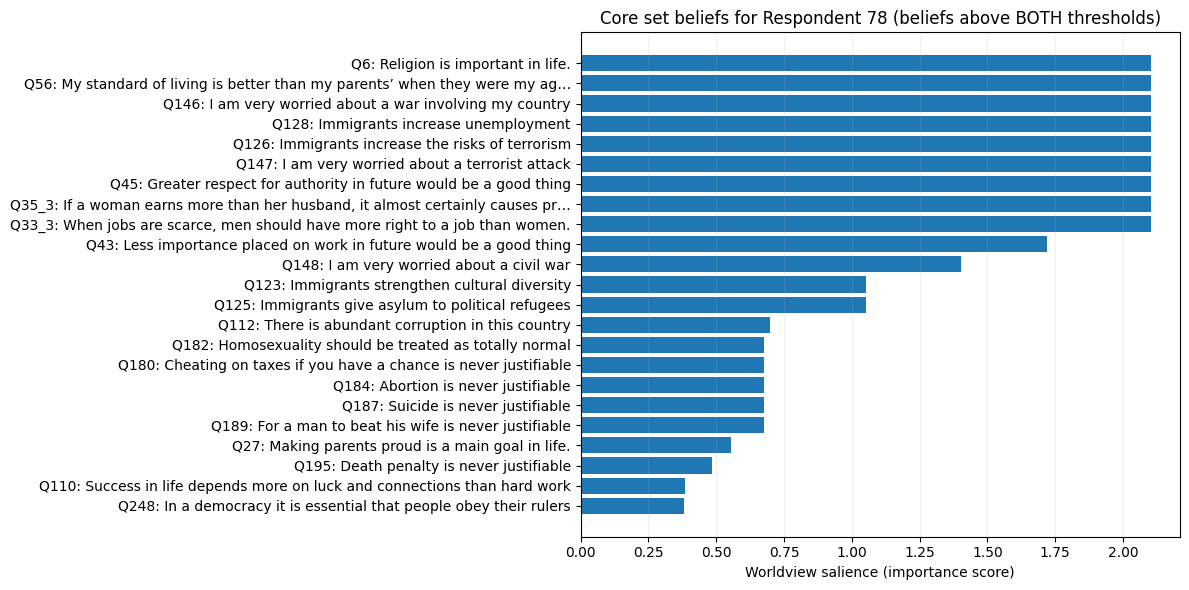

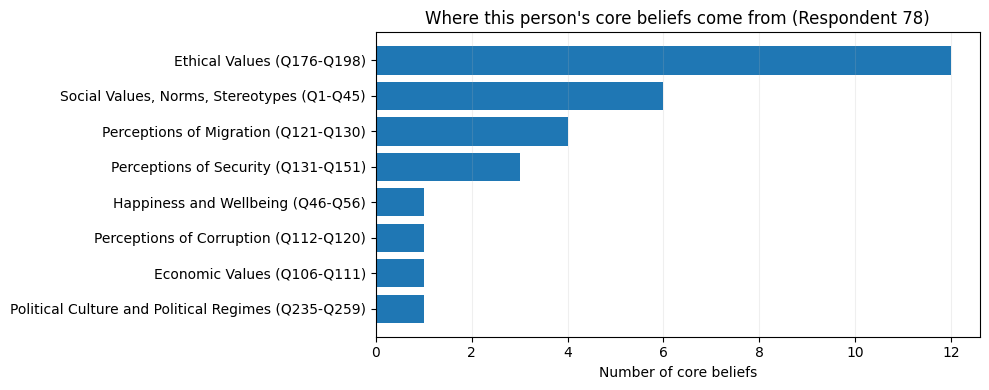

,Question_ID,Worldview_Statement,importance_score,Core_Variables
0,Q6,Religion is important in life.,2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
1,Q56,My standard of living is better than my parent...,2.104862,Happiness and Wellbeing (Q46-Q56)
2,Q146,I am very worried about a war involving my cou...,2.104862,Perceptions of Security (Q131-Q151)
3,Q128,Immigrants increase unemployment,2.104862,Perceptions of Migration (Q121-Q130)
4,Q126,Immigrants increase the risks of terrorism,2.104862,Perceptions of Migration (Q121-Q130)
5,Q147,I am very worried about a terrorist attack,2.104862,Perceptions of Security (Q131-Q151)
6,Q45,Greater respect for authority in future would ...,2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
7,Q35_3,"If a woman earns more than her husband, it alm...",2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
8,Q33_3,"When jobs are scarce, men should have more rig...",2.104862,"Social Values, Norms, Stereotypes (Q1-Q45)"
9,Q43,Less importance placed on work in future would...,1.718790,"Social Values, Norms, Stereotypes (Q1-Q45)"


In [70]:
# ============================================================
# 14) CORE SET BELIEFS (GREEN POINTS) — HISTOGRAM 




# --- Guard: make sure g exists and has rows ---
if g is None or g.shape[0] == 0:
    raise ValueError("g is empty. Run the worldview map first (plot_worldview_map_xy_green_all) and ensure it returns green beliefs.")

# --- 1) Prepare a clean 'core beliefs' table ---
core = g.loc[:, ["Question_ID", "Worldview_Statement", "importance_score", "Core_Variables"]].copy()

# shorten long statements for plotting labels
def shorten(s, n=70):
    s = "" if pd.isna(s) else str(s).strip()
    return s if len(s) <= n else s[: n-1] + "…"

core["Statement_short"] = core["Worldview_Statement"].apply(lambda x: shorten(x, 70))
core["Label"] = core["Question_ID"].astype(str) + ": " + core["Statement_short"]

# sort by importance for plotting
core = core.sort_values("importance_score", ascending=False).reset_index(drop=True)

# --- 2) HISTOGRAM / BAR: core beliefs by importance_score (slide-friendly) ---
plt.figure(figsize=(12, 6))
plt.barh(core["Label"][::-1], core["importance_score"][::-1])  # reverse so top is at top
plt.xlabel("Worldview salience (importance score)")
plt.ylabel("")  # cleaner slide
plt.title(f"Core set beliefs for Respondent {person_id} (beliefs above BOTH thresholds)")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

# --- 3) (Optional) count core beliefs by category (helps interpretation) ---
cat_summary = (
    core.groupby("Core_Variables")
        .agg(n_core_beliefs=("Question_ID", "count"),
             mean_importance=("importance_score", "mean"))
        .reset_index()
        .sort_values(["n_core_beliefs", "mean_importance"], ascending=False)
)

plt.figure(figsize=(10, 4))
plt.barh(cat_summary["Core_Variables"][::-1], cat_summary["n_core_beliefs"][::-1])
plt.xlabel("Number of core beliefs")
plt.title(f"Where this person's core beliefs come from (Respondent {person_id})")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

# --- 4) Display a clean table for report/slide copy-paste ---
display_cols = ["Question_ID", "Worldview_Statement", "importance_score", "Core_Variables"]
display(core[display_cols])




[debug] plotting person_id=1007, adjustText=True
[debug] rows after dropna(d_pop,z_iq): 73
[debug] green count: 15


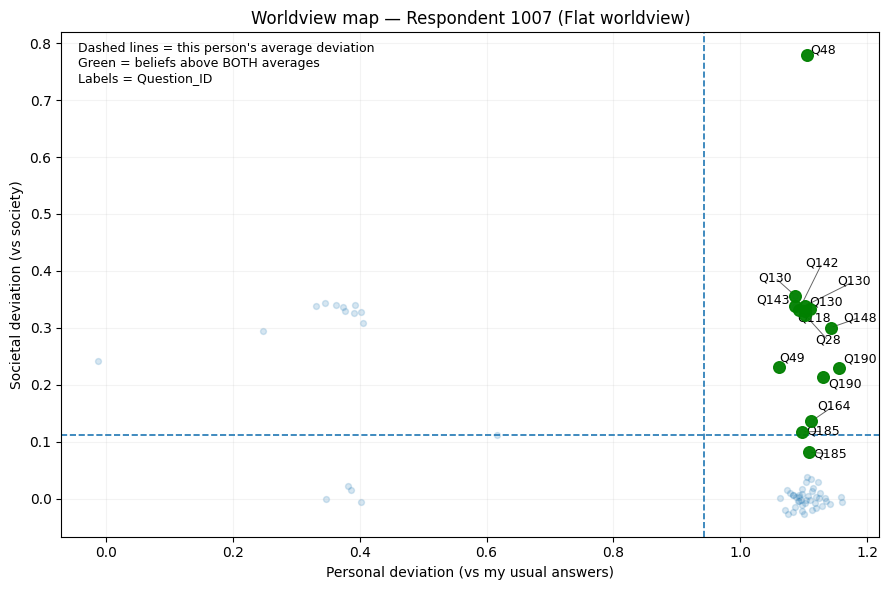

In [42]:
# ============================================================
# FLAT WORLDVIEW CASE
# ============================================================

person_id_flat = flat_id  # make sure this exists

g_flat = plot_worldview_map_xy_green_all(
    person_id_flat,
    df=df,
    title_suffix=" (Flat worldview)"
)


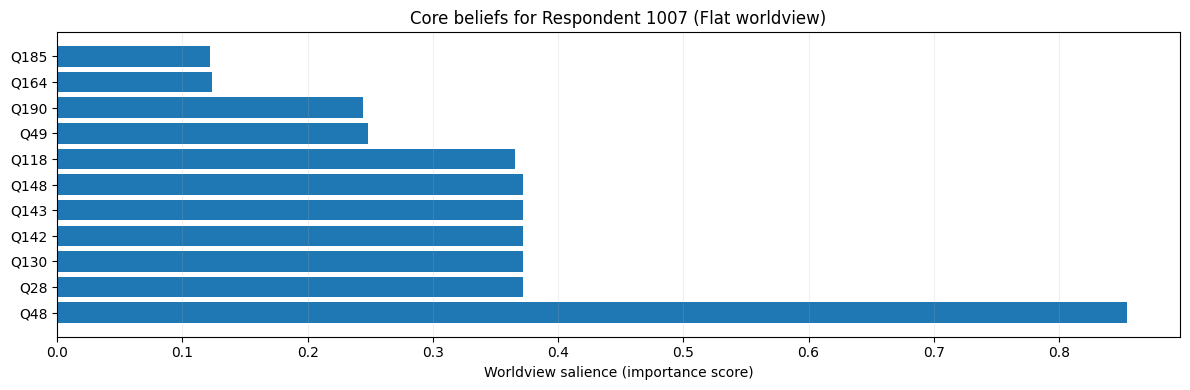

,Question_ID,Worldview_Statement,importance_score,Core_Variables
48673,Q48,I have freedom of choice and control over my l...,0.853934,Happiness and Wellbeing (Q46-Q56)
12709,Q28,"When a mother works for pay, children suffer.",0.371811,"Social Values, Norms, Stereotypes (Q1-Q45)"
92914,Q130,The government should let people from other co...,0.371811,Perceptions of Migration (Q121-Q130)
92915,Q130,The government should let people from other co...,0.371811,Perceptions of Migration (Q121-Q130)
92916,Q130,The government should let people from other co...,0.371811,Perceptions of Migration (Q121-Q130)
109050,Q142,I am very worried about losing or not finding ...,0.371811,Perceptions of Security (Q131-Q151)
110608,Q143,I am very worried about not giving my children...,0.371811,Perceptions of Security (Q131-Q151)
115422,Q148,I am very worried about a civil war,0.371811,Perceptions of Security (Q131-Q151)
72824,Q118,People frequently or always have to pay bribes...,0.365972,Perceptions of Corruption (Q112-Q120)
50359,Q49,I am satisfied with my life as a whole.,0.247874,Happiness and Wellbeing (Q46-Q56)


In [43]:
# ============================================================
# CORE BELIEFS — HISTOGRAM (FLAT CASE)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

if g_flat is None or g_flat.shape[0] == 0:
    print("Flat worldview: no core beliefs detected above thresholds.")
else:
    core_flat = g_flat.loc[:, [
        "Question_ID", "Worldview_Statement",
        "importance_score", "Core_Variables"
    ]].copy()

    core_flat = core_flat.sort_values("importance_score", ascending=False)

    plt.figure(figsize=(12, 4))
    plt.barh(
        core_flat["Question_ID"].astype(str),
        core_flat["importance_score"]
    )
    plt.xlabel("Worldview salience (importance score)")
    plt.title(f"Core beliefs for Respondent {person_id_flat} (Flat worldview)")
    plt.grid(axis="x", alpha=0.2)
    plt.tight_layout()
    plt.show()

    display(core_flat)


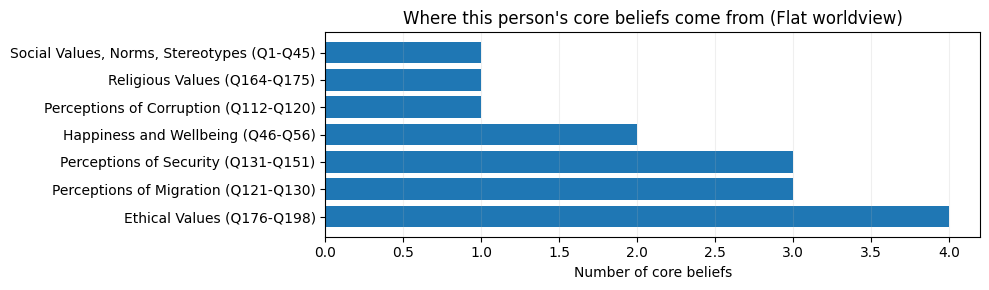

,Core_Variables,n_core_beliefs
0,Ethical Values (Q176-Q198),4
3,Perceptions of Migration (Q121-Q130),3
4,Perceptions of Security (Q131-Q151),3
1,Happiness and Wellbeing (Q46-Q56),2
2,Perceptions of Corruption (Q112-Q120),1
5,Religious Values (Q164-Q175),1
6,"Social Values, Norms, Stereotypes (Q1-Q45)",1


In [44]:
# ============================================================
# DOMAIN DISTRIBUTION — FLAT CASE
# ============================================================

if g_flat is None or g_flat.shape[0] == 0:
    print("Flat worldview: no domain concentration (no core beliefs).")
else:
    cat_flat = (
        g_flat.groupby("Core_Variables")
        .agg(n_core_beliefs=("Question_ID", "count"))
        .reset_index()
        .sort_values("n_core_beliefs", ascending=False)
    )

    plt.figure(figsize=(10, 3))
    plt.barh(
        cat_flat["Core_Variables"],
        cat_flat["n_core_beliefs"]
    )
    plt.xlabel("Number of core beliefs")
    plt.title(f"Where this person's core beliefs come from (Flat worldview)")
    plt.grid(axis="x", alpha=0.2)
    plt.tight_layout()
    plt.show()

    display(cat_flat)
